<a href="https://colab.research.google.com/github/Doris-QZ/nlp-disaster_tweets/blob/main/RNN_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction   

In this Kaggle competition, [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/overview), my goal is to build a deep learning model---specifically, a Recurrent Neural Network(RNN) ---to predict whether a given tweet is about a real disaster (class 1) or not(class 0).

### Data   

The training set contains 7613 records with five attributes: `id`, `keyword`, `location`, `text`, and `target`, where the `text` column contains tweets and the `target` column provides the label of the tweet (1: disaster, 0: non-disaster).


**Data Source:** Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.


**Connect to kaggle and download the dataset**

In [ ]:
# Install Kaggle library
!pip install kaggle

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Make a directory for Kaggle
!mkdir ~/.kaggle

# Copy the kaggle.json file to the directory
! cp /content/drive/MyDrive/ColabNotebooks/Kaggle_API_Key/kaggle.json ~/.kaggle/

# Change the file permissions to read/write to the owner only
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle competitions download nlp-getting-started

# Unzio the data
! unzip nlp-getting-started.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists
nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  nlp-getting-started.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#!pip install keras-tuner

In [ ]:
# Import important packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# EDA and Data preprocessing
import re
import spacy
from scipy.stats import f_oneway
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

# Word Embedding
from transformers import BertTokenizer, BertModel
import torch

# Modeling
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, GRU, Dense, Activation, Flatten, Dropout, Concatenate, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.metrics import binary_crossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import keras_tuner
from kerastuner.tuners import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler


<ipython-input-3-e58604e202dc>:29: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


In [ ]:
# Load the data
raw_train = pd.read_csv('/content/train.csv')
raw_test = pd.read_csv('/content/test.csv')
sample_submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
# Take a look at the data
print(raw_train.info())
print()
print(raw_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


There are 7613 records with 5 attributes in the training set, and 3263 records with 4 attributes in the test set. Both the 'keyword' and 'location' attribute have null values in both dataset.

### Preliminary Data Cleaning  
  
First, let's take a closer examination on the two attributes with null values.    

In [ ]:
# Make a copy of the train and test set
clean_train = raw_train.copy()
clean_test = raw_test.copy()

In [ ]:
# Examine the 'keyword' attribute
print('The proportion of null value is', '{:.1%}'.format(clean_train.keyword.isnull().sum() / clean_train.shape[0]))
clean_train.keyword.value_counts()

The proportion of null value is 0.8%


,count
keyword,
fatalities,45
armageddon,42
deluge,42
harm,41
damage,41
...,...
forest%20fire,19
epicentre,12
threat,11


There are 0.8% of null values and 221 unique values in the 'keyword' attribute. I will clean the 'keyword' column and add it to the cleaned text later.

In [ ]:
# Define a function to clean keyword column
def clean_keyword(keyword):
    keyword.fillna('', inplace = True)   # replace nan with '', the sentiment score would be 0 (neural)
    keyword = keyword.str.replace('%20', ' ')   # replace '%20', the URL-encoded representation of a space character, with a space
    keyword = keyword.str.replace(r'\s+', ' ', regex = True)  # remove extra space
    return keyword

In [ ]:
# Clean keyword on train and test data
clean_train['keyword'] = clean_keyword(clean_train['keyword'])
clean_test['keyword'] = clean_keyword(clean_test['keyword'])

In [ ]:
# Examine the 'location' attribute
print('There are', '{:.1%}'.format(clean_train.location.isnull().sum() / clean_train.shape[0]), 'null value in location.')
print('There are', len(clean_train.location.unique()), 'unique values in location')

There are 33.3% null value in location.
There are 3342 unique values in location


The 'location' attribute indicates where the tweet comes from, which is random and not necessarily associated with a disaster (also random). Given the relatively large proportion of missing values (33.3%) and the high number of unique values (3,342), I will drop this column from both the training and test sets.

In [ ]:
# Drop the 'location' column
clean_train = clean_train.drop(columns = 'location')
clean_test = clean_test.drop(columns = 'location')

Now, let's take a look at the 'text' column.

In [ ]:
# Take a look at the text in each target
pd.set_option('display.max_colwidth', 200)

for category, group in clean_train.groupby('target'):
    print(f'target: {category}')
    print(group['text'].str.ljust(200).sample(6))
    print()

target: 0
2925    http://t.co/MoA0q0AuFa Jacksonville family bands together as memorial is planned for toddler who ... - FloridaÛ_ http://t.co/NKOu7zWwRT                                                            ...
652     My hair is poverty at the moment need to get a fade before the weekend gets here                                                                                                                    ...
600     #BreakingNews http://t.co/gAN14PW9TG FedEx no longer willing to transport research specimens of potential bioterÛ_ http://t.co/5n4hUsewLy                                                          ...
883     Add these items to your everyday eating habits. Please do the research on how to take with your bloodÛ_ https://t.co/LnpsCaDaXr                                                                    ...
340     Lee does comedy: ÛÏ@LeeJasper: Working class Tories prepare for your Armageddon. #InterestRateRiseÛ                                                

As we can see from the tweets above, there are many mentions (@), hashtags(#), URLs, abbreviation, and irregular usage of punctuations. Before further cleaning the text, I will extract the following meta features from the tweets:  
* Number of mentions (@) in a tweet;  
* Number of hashtags (#) in a tweet;  
* Number of URLs in a tweet;  
* Number of irregular usage of punctuations in a tweet.


In [ ]:
# Define a function to extract the meta features from the text
def meta_features(text):
    mentions = len(re.findall(r'@\w+', text))   # count mentions (@)
    hashtags = len(re.findall(r'#\w+', text))   # count hashtags (#)
    urls = len(re.findall(r'https?\S+', text))  # count URLs
    irre_punt = len(re.findall(r'[?!]{2,}', text))  # count irregular usage of punctuations

    return pd.Series({
        'num_mentions': mentions,
        'num_hashtags': hashtags,
        'num_urls': urls,
        'irregular_punctuation': irre_punt
    })

# Add columns of meta features to train and test set
clean_train = pd.concat([clean_train, clean_train['text'].apply(meta_features)], axis = 1)
clean_test = pd.concat([clean_test, clean_test['text'].apply(meta_features)], axis = 1)

I will perform minimal cleaning(such as removing URLs, mentions, and hashtags) on the text data to preserve context for BERT Embedding, inspired by this [blog](https://towardsdatascience.com/does-bert-need-clean-data-part-2-classification-d29adf9f745a).  

In [ ]:
# Define a function for minimal cleaning
def minimal_cleaning(text):
    text = text.replace('\n', ' ')           # replace the newline character with a space
    text = text.replace('w/', 'with ')        # replace w/ with 'with'
    text = text.replace('&amp', 'and')       # replace &amp with 'and'
    text = text.replace('Ûªm', 'am')
    text = re.sub(r'\S*&gt\S*', ' ', text)   # remove symbol '&gt'
    text = re.sub(r'\S*&lt\S*', ' ', text)   # remove symbol '&lt'
    text = re.sub(r'[^\x00-\x7F]', ' ', text)  # remove non-ASCII letters
    text = re.sub(r'https?\S+', ' ', text)  # remove urls
    text = re.sub(r'@\S+', ' ', text)     # remove mentions
    text = re.sub(r'#\S+', '', text) # remove hashtags
    text = re.sub(r'\s+', ' ', text)  # remove extra space

    return text

In [ ]:
# Add new columns of 'cleaned_text' to clean_train and clean_test dataframe
clean_train['cleaned_text'] = clean_train['text'].apply(minimal_cleaning)
clean_test['cleaned_text'] = clean_test['text'].apply(minimal_cleaning)

The text column is clean now, and I will check if there are any duplicated rows in the training set.

In [ ]:
# Check the number of duplicated text with the same target labels
print('There are', clean_train[clean_train.duplicated(subset = ['cleaned_text', 'target'])].shape[0], 'duplicated text with the same target labels.')

There are 653 duplicated text with the same target labels.


In [ ]:
# Drop duplicated text with the same target labels, keep only the first occurrence
clean_train = clean_train.drop_duplicates(subset = ['cleaned_text', 'target'])

In [ ]:
# Check the number of duplicated text with different target labels
print('There are', clean_train[clean_train.duplicated(subset = 'cleaned_text', keep = False)].shape[0], 'duplicated text with different target labels.')

There are 162 duplicated text with different target labels.


I will remove the duplicates tweets with different target labels to avoid confusion while modeling.

In [ ]:
# Drop duplicated text with the different target labels
clean_train = clean_train.drop_duplicates(subset = ['cleaned_text'], keep = False)

In [ ]:
# Concatenate 'keyword' with 'cleaned_text'
clean_train['cleaned_text'] = clean_train['keyword'].str.cat(others = clean_train['cleaned_text'], sep = '. ')
clean_test['cleaned_text'] = clean_test['keyword'].str.cat(others = clean_test['cleaned_text'], sep = '. ')

In [ ]:
# Remove the '. ' in the begining of a string (rows with no keyword)
clean_train['cleaned_text'] = clean_train['cleaned_text'].str.replace(r'^\. ', '', regex = True)
clean_test['cleaned_text'] = clean_test['cleaned_text'].str.replace(r'^\. ', '', regex = True)

In [ ]:
# Drop the columns of 'keyword' and 'text'
clean_train = clean_train.drop(columns = ['keyword', 'text'])
clean_test = clean_test.drop(columns = ['keyword', 'text'])

# Rename the column 'target' to avoid ambiguous ('target' could be both an index level and a column label in a word count dataframe which we will create later)
clean_train.rename(columns = {'target': 'Target'}, inplace = True)

In [ ]:
# Reset index of the training set
clean_train = clean_train.reset_index(drop = True)

clean_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6798 entries, 0 to 6797
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     6798 non-null   int64 
 1   Target                 6798 non-null   int64 
 2   num_mentions           6798 non-null   int64 
 3   num_hashtags           6798 non-null   int64 
 4   num_urls               6798 non-null   int64 
 5   irregular_punctuation  6798 non-null   int64 
 6   cleaned_text           6798 non-null   object
dtypes: int64(6), object(1)
memory usage: 371.9+ KB


**Summary of Data Cleaning**  

Here’s what I have done during the preliminary data cleaning:

* Cleaned the ‘keyword’ attribute.
* Dropped the ‘location’ attribute as it doesn’t contribute much to classifying a tweet.
* Extracted meta features from the text data, which will be further examined during Exploratory Data Analysis.
* Performed minimal cleaning on text data to preserve context for BERT Embedding.
* Concatenated 'keyword' with 'cleaned_text', and drop the 'keyword' and 'text' columns.
* Dropped duplicate rows, especially those with same tweets but different labels, to avoid confusion.    

# Exploratory Data Analysis (EDA)  

I will explore a few linguistic features that reflect the writting style of tweets in different categories(disaster or non-disaster) from the following perspectives:  

* Sentence Length: the average length of sentences.
* Word Length: the average length of words.
* Word Frequency: the most frequency words and bi-grams used in each category of tweets.  

First, let's check the sentence length and word length of each tweets.

In [ ]:
# Load the pre-trained English model from spaCy
nlp = spacy.load('en_core_web_sm')

# Define a function to extract sentence length and word length
def linguistic_features(text):

  # create a Doc container using spaCy package
  text = text.lower()
  doc = nlp(text)

  # Sentence length
  sentence_len = [len(sent) for sent in doc.sents]
  sentence_len = np.mean(sentence_len) if sentence_len else 0

  # Word length
  word_len = [len(token.text) for token in doc if token.is_alpha]
  word_len = np.mean(word_len) if word_len else 0

  return pd.Series({
      'sentence_len': sentence_len,
      'word_len': word_len
  })

In [ ]:
# Add columns of linguistic features to train and test set
clean_train = pd.concat([clean_train, clean_train['cleaned_text'].apply(linguistic_features)], axis = 1)
clean_test = pd.concat([clean_test, clean_test['cleaned_text'].apply(linguistic_features)], axis = 1)

I will take a closer look at both meta features and linguistic features, and then examine the association between these features and the target label using ANOVA test.

In [ ]:
clean_train[['num_mentions', 'num_hashtags', 'num_urls', 'irregular_punctuation',
             'sentence_len', 'word_len']].describe()

,num_mentions,num_hashtags,num_urls,irregular_punctuation,sentence_len,word_len
count,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000
mean,0.380847,0.409826,0.566196,0.111650,7.815036,4.977519
std,0.732501,0.999354,0.648411,0.390459,3.091946,0.988373
min,0.000000,0.000000,0.000000,0.000000,1.000000,2.600000
25%,0.000000,0.000000,0.000000,0.000000,5.500000,4.281429
50%,0.000000,0.000000,0.000000,0.000000,7.500000,4.863636
75%,1.000000,0.000000,1.000000,0.000000,9.500000,5.562500
max,8.000000,13.000000,4.000000,9.000000,37.000000,11.333333


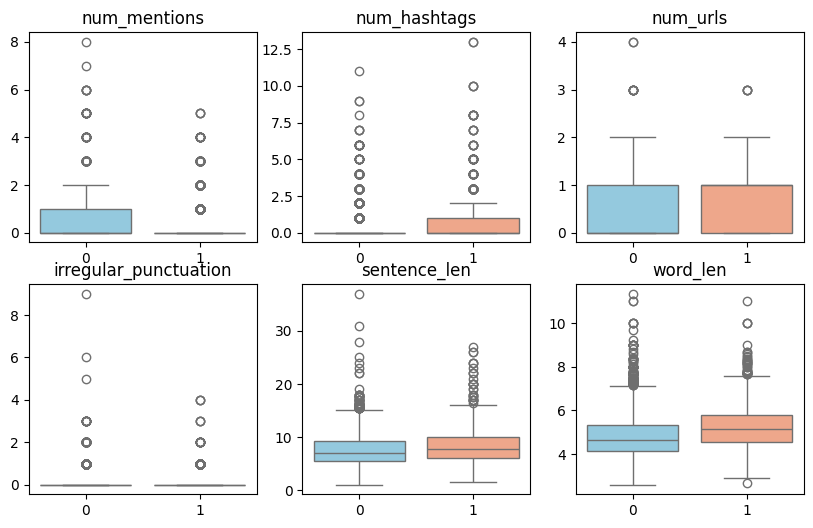

In [ ]:
# Create a figure with 6 plots
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (10, 6))

# Flatten the axes for easy iteration
axes = axes.flatten()

# The column names of both meta features and linguistic features
meta_lingu = ['num_mentions', 'num_hashtags', 'num_urls', 'irregular_punctuation',
             'sentence_len', 'word_len']

# Plot the meta feature and linguistic feature
for i, col in enumerate(meta_lingu):
  sns.boxplot(data = clean_train, x = 'Target', y = col, hue = 'Target',
              palette = ['skyblue', 'lightsalmon'], legend = False, ax = axes[i])
  axes[i].set_ylabel('')
  axes[i].set_xlabel('')
  axes[i].set_title(col);


As shown in the plots above, the non-disaster tweets contain more mentions and less hashtags, while the disaster tweets tend to use longer sentences and words. There is not obvisous deviations between the two categories in terms of number of urls or irregular punctuations.  

I will use an ANOVA test to further determine if there are statistically significant differences between the means of these features across the two categories, setting alpha = 0.05.  

In [ ]:
# Unique value in 'Target'
categories = clean_train['Target'].unique()

# Apply ANOVA for each feature across the categories
for feature in meta_lingu:
  #Create groups for each category
  groups = [clean_train[clean_train['Target'] == category][feature] for category in categories]

  # Perform one-way ANOVA
  f_statistic, p_value = f_oneway(*groups)

  # Print results
  print(f"Feature: {feature}, p-value: {p_value: .3f}")


Feature: num_mentions, p-value:  0.000
Feature: num_hashtags, p-value:  0.000
Feature: num_urls, p-value:  0.000
Feature: irregular_punctuation, p-value:  0.000
Feature: sentence_len, p-value:  0.000
Feature: word_len, p-value:  0.000


All of the p-values above are much less than 0.05, with all values equal to 0. This suggests that there are statistically significant differences between the two categories in terms of the number of mentions, hashtags, URLs, irregular punctuation usage, sentence length, and word length.  

There are two categories in the target variable: 1 represents 'disaster' and 0 represents 'not disaster'. I'll check the proportion of each category in the training set to see if it is balanced.    

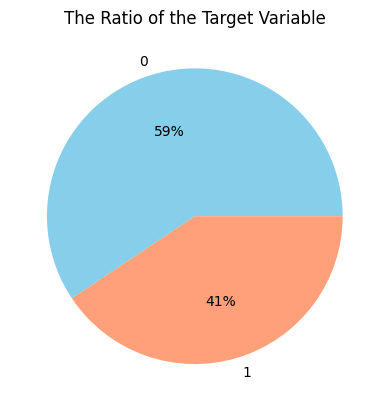

In [ ]:
# Check the value count of the 'target' variable
labels = clean_train['Target'].value_counts().index
values = clean_train['Target'].value_counts().values

plt.pie(values, labels = labels, colors = ['skyblue', 'lightsalmon'], autopct = '%1.0f%%')
plt.title('The Ratio of the Target Variable');

The training set is slightly imbalanced, with 59% labeled as 0 (not disaster) and 41% labeled as 1 (disaster).  

Now let's check the most common words in each category.

In [ ]:
# Create a countvectorizer
cnt_vt = CountVectorizer(ngram_range = (1, 2), stop_words= 'english')

# Transform the 'cleaned_text' into a word count matrix
word_cnt_mx = cnt_vt.fit_transform(clean_train['cleaned_text'])

# Convert the word count matrix into to dataframe
word_cnt_df = pd.DataFrame(word_cnt_mx.toarray(), columns = cnt_vt.get_feature_names_out(),
                           index = clean_train['Target'])

# Group the dataframe by 'Target'
word_cnt = word_cnt_df.groupby('Target').sum()
word_cnt = word_cnt.reset_index()

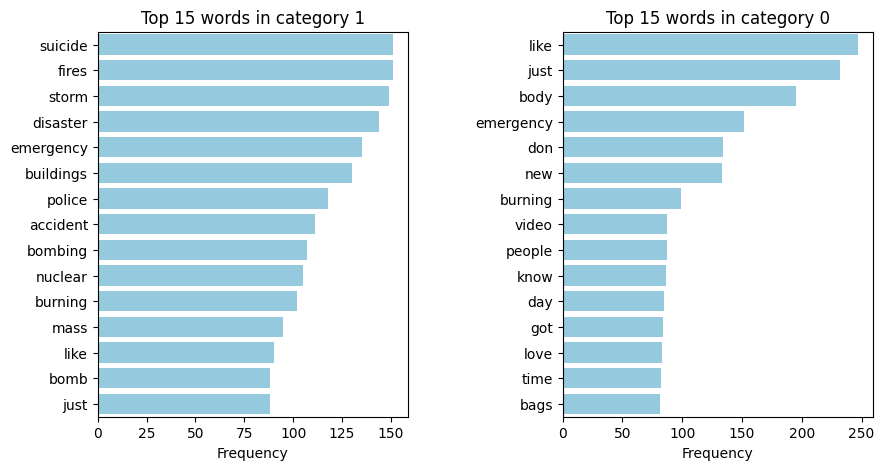

In [ ]:
# Define a function to plot top words
def plot_top_words(category, n, ax):
    df = word_cnt[word_cnt['Target'] == category].drop(columns = 'Target').T
    df.columns = ['Frequency']
    df = df.sort_values(by = 'Frequency', ascending = False).head(n)

    sns.barplot(x = df['Frequency'], y = df.index, color = 'skyblue', ax = ax)
    ax.set_title(f'Top {n} words in category {category}')
    ax.set_ylabel('')

    return ax

# Plot top 15 words of both categories
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
plt.subplots_adjust(wspace = 0.5)
for i, category in enumerate(clean_train['Target'].unique()):
    plot_top_words(category, 15, ax[i])

All of the top words in both categories are unigrams. While some of the top words in category 1 appear more intense, such as 'suicide', 'fire', 'storm', and 'disaster', there are also overlaps between the two categories, with words like 'emergency', 'burning', 'people', 'just', and 'like' appearing in both plots.

I will plot top bigrams of the two categories to see if it looks different.

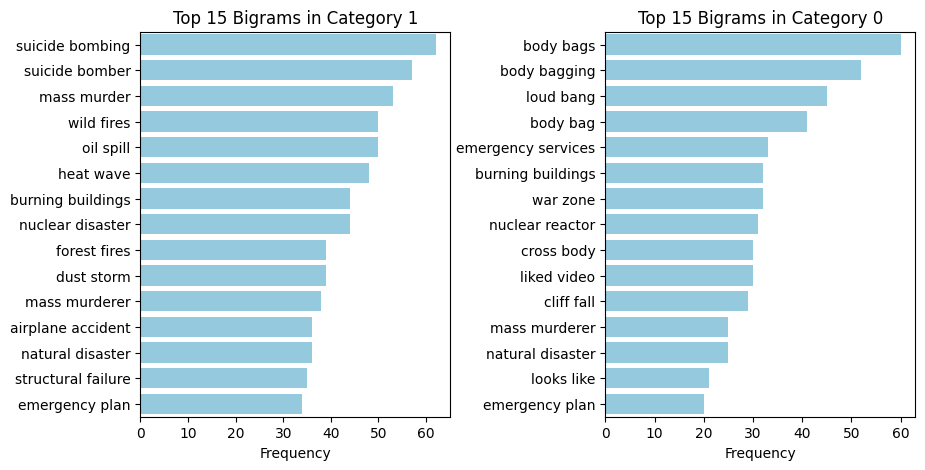

In [ ]:
# Define a function to plot top bigrams:
def plot_top_bigrams(category, n, ax):
    df = word_cnt[word_cnt['Target'] == category].drop(columns = 'Target').T
    df.columns = ['Frequency']
    df_bigrams = df[df.index.str.contains(' ')]
    df_bigrams = df_bigrams.sort_values(by = 'Frequency', ascending = False).head(n)

    sns.barplot(x = df_bigrams['Frequency'], y = df_bigrams.index, color = 'skyblue', ax = ax)
    ax.set_title(f'Top {n} Bigrams in Category {category}')
    ax.set_ylabel('')

    return ax

# Plot top 15 bigrams of both categories
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
plt.subplots_adjust(wspace = 0.5)
for i, category in enumerate(clean_train['Target'].unique()):
    plot_top_bigrams(category, 15, ax[i])

Similar to the previous top words plots, there are words we may naturally associate with 'disaster' appearing in the top 15 bigrams of category 0 (non-disaster), such as 'body bags' and 'mass murderer'. There are also overlaps between the two categories, with bigrams like 'burning buildings', 'natural disaster', and 'emergency plan' appearing in both plots.

These overlaps make the distinction between the two categories fairly small in terms of top words and bigrams.
  
    
**Summary of EDA**  
    
Here is what I have done during the EDA:  

* Extracted linguistic features from the text data, and discovered statistically significant difference between the two categories of tweets in terms of the number of mentions, hashtags, URLs, irregular punctuation usage, sentence length, and word length using an ANOVA test.

* Checked the proportion of each target label in the training set and discovered the slightly imbalanced nature of the dataset(59% vs. 41%).  

* Analyzed the top words in each target category and found that words we may naturally associate with 'disaster' appear in the plot for category 0 (non-disaster). There are also overlaps in both plots, making the distinction between the two categories fairly small in terms of top words.  
  

**Potential Challenges:**

**I. Imbalanced Dataset**  
  
The slightly imbalanced nature of the dataset might pose a challenge. I will first use the 'stratify' parameter when splitting the data into training and validation sets to ensure the same label distribution, and then set 'class_weight' parameter during training.  

**II. Overlaps of Top Words**  
  
The overlap of top words blurs the boundary between the two target labels, which might challenge the models we are about to build. Using a word embedding method that considers the context in which the word appears, such as BERT, might provide more valuable information in this case and perform better.  

In [ ]:
# Save clean_train and clean_test dataframe
clean_train.to_csv('/content/drive/MyDrive/ColabNotebooks/Disaster_tweets/clean_train.csv', index = False)
clean_test.to_csv('/content/drive/MyDrive/ColabNotebooks/Disaster_tweets/clean_test.csv', index = False)

### Modeling  

**Word Embedding**  

BERT embeddings are known for their ability to represent words in a way that captures their meaning within specific contexts. Given the challenge of overlapping words between the two target labels, BERT's contextual word embedding is a good choice.
  
**Model**  

Long Short-Term Memory (LSTM), a type of Recurrent Neural Network (RNN), will be used in this project. It is known for its capability to mitigate the vanishing gradient problem commonly encountered in traditional RNNs and is well-suited for handling sequential data, as RNNs do.

**Evaluation**  

For evaluation, accuracy will be used as the metric during training since it is more intuitive. However, when comparing different models, I will use `classification_report`, which includes key classification metrics such as precision, recall, and F1-score, to gain a more comprehensive understanding of model performance—especially given that the dataset is slightly imbalanced.

In [ ]:
# Split the 'clean_train' dataset into training and validation set
tra, val = train_test_split(clean_train, test_size = 0.2, stratify = clean_train['Target'], random_state = 6)

In [ ]:
# Load bert tokenizer and bert base model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Check the number of words in tweets
clean_train['cleaned_text'].str.split().str.len().describe()

,cleaned_text
count,6798.000000
mean,14.770815
std,6.110778
min,1.000000
25%,10.000000
50%,15.000000
75%,19.000000
max,32.000000


The maximum number of words in the tweets is 32. I will set the `max_length` of the BERT tokenizer to 40 to account for punctuation and potential split tokens due to unrecognized vocabulary.

In [ ]:
# Define a function to get the last hidden state of bert embedding
def bert_embedding(texts):
    inputs = bert_tokenizer(texts.tolist(), return_tensors='pt', padding=True, truncation=True,
                            add_special_tokens=True, max_length=40)
    with torch.no_grad():
      outputs = bert_model(**inputs)

    token_embeddings = outputs.last_hidden_state

    return token_embeddings.detach().numpy()

In [ ]:
# Reset the index of the training and validation datasets to ensure that the following code, which references the index, works correctly
tra = tra.reset_index(drop = True)
val = val.reset_index(drop = True)

# Get BERT Embeddings for tra and val dataset
tra_embeddings = bert_embedding(tra['cleaned_text'])
val_embeddings = bert_embedding(val['cleaned_text'])

# Save the embeddings as a Numpy file
np.save('/content/drive/MyDrive/ColabNotebooks/Disaster_tweets/tra_embeddings.npy', tra_embeddings)
np.save('/content/drive/MyDrive/ColabNotebooks/Disaster_tweets/val_embeddings.npy', val_embeddings)

In [ ]:
# Save tra and val just in case Google Colab disconnect
tra.to_csv('/content/drive/MyDrive/ColabNotebooks/Disaster_tweets/tra.csv', index = False)
val.to_csv('/content/drive/MyDrive/ColabNotebooks/Disaster_tweets/val.csv', index = False)

**First LTSM Model**

I will train a simple LSTM model with the following architecture---

* Structure: [LSTM(128)]-[Dense(64)]-[Sigmoid]
* Activation functions: ReLU for Dense layer, sigmoid for the output layer
* Regularization: L2 regularization, Batch Normalization, Dropout
* Opimization method: Adam
* Learning rate: start from 0.001
* Callbacks: Model Checkpoint, Early Stopping, Reduced learning rate

---as the dataset is not large, only 6798 samples in the entire training set after cleaning. Moreover, it has been split into an 80% training set and a 20% validation set

In [ ]:
BATCH_SIZE = 64

# Build a LSTM model
lstm1 = Sequential([
    LSTM(128, input_shape = (40, 768)),
    Dense(64, kernel_regularizer = l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    Dense(1, activation = 'sigmoid')
])

lstm1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 128)                 │         459,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 467,841 (1.78 MB)

 Trainable params: 467,713 (1.78 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# Compile the LSTM model with optimizer, loss function and metric
lstm1.compile(optimizer = Adam(learning_rate = 0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Compute class_weight
train_weight = compute_class_weight(class_weight = 'balanced', classes = np.unique(tra['Target']),
                                    y = tra['Target'])
train_weight = dict(enumerate(train_weight))
print(train_weight)

{0: 0.8420563641994425, 1: 1.2308736985061113}


In [ ]:
# Define callbacks
model_checkpoint = ModelCheckpoint(
    filepath = '/content/drive/MyDrive/ColabNotebooks/Disaster_tweets/disaster_tweets_lstm1.keras',
    monitor = 'val_accuracy',
    save_best_only = True,
    mode = 'max'
)

early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    verbose = 1,
    restore_best_weights = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 1e-6
)

In [ ]:
history1 = lstm1.fit(
    tra_embeddings,
    tra['Target'],
    steps_per_epoch = math.ceil(tra.shape[0]/BATCH_SIZE),
    batch_size = BATCH_SIZE,
    validation_data = (val_embeddings, val['Target']),
    validation_steps = math.ceil(val.shape[0]/BATCH_SIZE),
    epochs = 30,
    class_weight = train_weight,
    callbacks = [model_checkpoint, early_stopping, reduce_lr]
)

Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6925 - loss: 0.6767 - val_accuracy: 0.7963 - val_loss: 0.6009 - learning_rate: 0.0010
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8136 - loss: 0.5003 - val_accuracy: 0.7963 - val_loss: 0.5397 - learning_rate: 0.0010
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8378 - loss: 0.4493 - val_accuracy: 0.7875 - val_loss: 0.5307 - learning_rate: 0.0010
Epoch 4/30
81/85 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8578 - loss: 0.3938
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8582 - loss: 0.3928 - val_accuracy: 0.7449 - val_loss: 0.5872 - learning_rate: 0.0010
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8903 - loss: 0.3297 - val_accuracy: 0.7971 - val_loss: 0.5283 - learning_rate: 5.0000e-04
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9135 - loss: 0.2774 - val_

The model stopped training at epoch 10. The best validation accuracy 0.7971 occurs in epoch 5, when the training accuracy was 0.8903. The training accuracy continue improving after that, while the validation accuracy fluctuated, indicating an overfitting.

I will add the meta and linguistic features into the model, before the dense layer, and see if it improves the performance.

**Add meta & linguistics features**


In [ ]:
# Extra meta & linguistic features from tra and val dataset
meta_tra = tra[['num_mentions', 'num_hashtags', 'num_urls', 'irregular_punctuation',
                'sentence_len', 'word_len']]
meta_val = val[['num_mentions', 'num_hashtags', 'num_urls', 'irregular_punctuation',
                'sentence_len', 'word_len']]

# Normalize the meta & linguistic features
meta_tra = StandardScaler().fit_transform(meta_tra)
meta_val = StandardScaler().fit_transform(meta_val)

In [ ]:
# Define a function to build the model
def build_model(lstm_units, dense_units, l2_rate, dropout_rate):
  # Define the input for BERT Embedding
  input_bert = Input(shape = (40, 768))

  # LSTM Layer to process the BERT Embeddings
  x = LSTM(lstm_units)(input_bert)

  # Define the input for meta features
  input_meta = Input(shape = (6,))

  # Concatenate the output of LSTM with the meta features
  x = Concatenate()([x, input_meta])

  # Dense layer
  x = Dense(dense_units, kernel_regularizer = l2(l2_rate))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(dropout_rate)(x)

  # Output layer
  output = Dense(1, activation = 'sigmoid')(x)

  # Create the model
  model = Model(inputs = [input_bert, input_meta], outputs = output)

  return model

In [ ]:
lstm_meta = build_model(128, 64, 0.001, 0.3)
lstm_meta.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 40, 768)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 128)            │        459,264 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 134)            │              0 │ lstm_1[0][0],          │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,640 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64)             │            256 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 64)             │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             65 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 468,225 (1.79 MB)

 Trainable params: 468,097 (1.79 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# Compile the LSTM model with optimizer, loss function and metric
lstm_meta.compile(optimizer = Adam(learning_rate = 0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Define callbacks
model_checkpoint_meta = ModelCheckpoint(
    filepath = '/content/drive/MyDrive/ColabNotebooks/Disaster_tweets/disaster_tweets_lstm_meta.keras',
    monitor = 'val_accuracy',
    save_best_only = True,
    mode = 'max'
)

history_meta = lstm_meta.fit(
    [tra_embeddings, meta_tra],
    tra['Target'],
    steps_per_epoch = math.ceil(tra.shape[0]/BATCH_SIZE),
    batch_size = BATCH_SIZE,
    validation_data = ([val_embeddings, meta_val], val['Target']),
    validation_steps = math.ceil(val.shape[0]/BATCH_SIZE),
    epochs = 30,
    class_weight = train_weight,
    callbacks = [model_checkpoint_meta, early_stopping, reduce_lr]
)

Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7343 - loss: 0.6576 - val_accuracy: 0.6471 - val_loss: 0.7001 - learning_rate: 0.0010
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8090 - loss: 0.5174 - val_accuracy: 0.7610 - val_loss: 0.5553 - learning_rate: 0.0010
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8289 - loss: 0.4643 - val_accuracy: 0.7824 - val_loss: 0.5338 - learning_rate: 0.0010
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8464 - loss: 0.4173 - val_accuracy: 0.7809 - val_loss: 0.5358 - learning_rate: 0.0010
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8736 - loss: 0.3598 - val_accuracy: 0.7882 - val_loss: 0.5320 - learning_rate: 0.0010
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8973 - loss: 0.3065 - val_accuracy: 0.7463 - val_loss: 0.8378 - learning_rate: 0.0010
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9196 - loss: 0.2445 - val_acc

The best validation accuracy is 0.7882, suggesting that adding meta and linguistic features into the model does not improve the performance.

**Tune the LSTM Model**

I will tune the following hyperparameter of the LSTM model using `BayesianOptimization` from `keras_tunner`:  

* Number of units in LSTM layer
* Number of units in Dense layer
* l2 regularizer values
* Activation function of Dense layer
* Dropout rate values
* Learning rate

In [ ]:
def build_model(hp):
  model = Sequential([
    LSTM(units = hp.Int('lstm_units', min_value = 16,
                        max_value = 128, step = 16),
         input_shape = (40, 768)),
    Dense(units = hp.Int('dense_units', min_value = 16,
                         max_value = 128, step = 16),
          kernel_regularizer = l2(hp.Choice('l2', values = [0.01, 0.001]))),
    BatchNormalization(),
    Activation(hp.Choice('activation', values = ['relu', 'leaky_relu'])),
    Dropout(hp.Choice('dropout', values = [0.3, 0.4, 0.5])),
    Dense(1, activation = 'sigmoid')
])
  model.compile(optimizer = Adam(learning_rate = hp.Choice('learning_rate',
                                                           values = [0.001, 0.0001])),
              loss = 'binary_crossentropy',
              metrics = ['accuracy']
  )
  return model

tuner = BayesianOptimization(
    build_model,
    objective = 'val_accuracy',
    max_trials = 100
)

tuner.search(tra_embeddings,
    tra['Target'],
    batch_size = BATCH_SIZE,
    validation_data = (val_embeddings, val['Target']),
    epochs = 30,
    class_weight = train_weight,
    callbacks = [early_stopping, reduce_lr])

Trial 100 Complete [00h 00m 42s]
val_accuracy: 0.8154411911964417

Best val_accuracy So Far: 0.8242647051811218
Total elapsed time: 00h 50m 23s


The best validation accuracy during hyperparameter tuning was 0.8242. I will check the hyperparameters of the top-3 models.

In [ ]:
# Get the optimal hyperparameters
best_hps1, best_hps2, best_hps3 = tuner.get_best_hyperparameters(num_trials = 3)[0:3]
print('Top One:')
print('lstm_units:', best_hps1.get('lstm_units'), ' ', 'dense_units:', best_hps1.get('dense_units'), ' ',
      'l2:', best_hps1.get('l2'), ' ', 'activation:', best_hps1.get('activation'), ' ',
      'dropout:', best_hps1.get('dropout'), ' ', 'learning_rate:', best_hps1.get('learning_rate'))
print('')

print('Top Two:')
print('lstm_units:', best_hps2.get('lstm_units'), ' ', 'dense_units:', best_hps2.get('dense_units'), ' ',
      'l2:', best_hps2.get('l2'), ' ', 'activation:', best_hps2.get('activation'), ' ',
      'dropout:', best_hps2.get('dropout'), ' ', 'learning_rate:', best_hps2.get('learning_rate'))
print('')

print('Top Three:')
print('lstm_units:', best_hps3.get('lstm_units'), ' ', 'dense_units:', best_hps3.get('dense_units'), ' ',
      'l2:', best_hps3.get('l2'), ' ', 'activation:', best_hps3.get('activation'), ' ',
      'dropout:', best_hps3.get('dropout'), ' ', 'learning_rate:', best_hps3.get('learning_rate'))
print('')

Top One:
lstm_units: 32   dense_units: 16   l2: 0.01   activation: relu   dropout: 0.5   learning_rate: 0.001

Top Two:
lstm_units: 96   dense_units: 16   l2: 0.001   activation: relu   dropout: 0.5   learning_rate: 0.001

Top Three:
lstm_units: 96   dense_units: 80   l2: 0.001   activation: relu   dropout: 0.3   learning_rate: 0.0001



In [ ]:
# Get the top-3 best models
best_models = tuner.get_best_models(num_models = 3)
tuned_lstm1 = best_models[0]
tuned_lstm2 = best_models[1]
tuned_lstm3 = best_models[2]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Result and Analysis



In [ ]:
# Compare the three models' performance using classification reports
pred_proba_tuned_lstm1 = tuned_lstm1.predict(val_embeddings, verbose = 0)
pred_tuned_lstm1 = np.round(pred_proba_tuned_lstm1).astype(int)

pred_proba_tuned_lstm2 = tuned_lstm2.predict(val_embeddings, verbose = 0)
pred_tuned_lstm2 = np.round(pred_proba_tuned_lstm2).astype(int)

pred_proba_tuned_lstm3 = tuned_lstm3.predict(val_embeddings, verbose = 0)
pred_tuned_lstm3 = np.round(pred_proba_tuned_lstm3).astype(int)

y_true = val['Target']

print('Model_1: tuned_lstm1')
print(classification_report(y_true, pred_tuned_lstm1))

print('Model_2: tuned_lstm2')
print(classification_report(y_true, pred_tuned_lstm2))

print('Model_3: tuned_lstm3')
print(classification_report(y_true, pred_tuned_lstm3))

Model_1: tuned_lstm1
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       807
           1       0.83      0.72      0.77       553

    accuracy                           0.82      1360
   macro avg       0.82      0.81      0.81      1360
weighted avg       0.82      0.82      0.82      1360

Model_2: tuned_lstm2
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       807
           1       0.83      0.70      0.76       553

    accuracy                           0.82      1360
   macro avg       0.82      0.80      0.81      1360
weighted avg       0.82      0.82      0.82      1360

Model_3: tuned_lstm3
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       807
           1       0.81      0.72      0.76       553

    accuracy                           0.82      1360
   macro avg       0.82      0.80      0.81      1360
weighted av

All three models have the same accuracy (0.82), while the first two models perform slightly better than the third on in terms of macro and weighted average F1-score, and precision for class 1.  

I will rebuild the top two models using the corresponding hyperparameter sets, then train it again to get the history.

In [ ]:
# Build the top two models with the optimal hyperparameters
tuned_lstm1_new = tuner.hypermodel.build(best_hps1)
tuned_lstm2_new = tuner.hypermodel.build(best_hps2)


# Define callbacks
model_checkpoint_tuned_lstm1 = ModelCheckpoint(
    filepath = '/content/drive/MyDrive/ColabNotebooks/Disaster_tweets/disaster_tweets_tuned_lstm1_new.keras',
    monitor = 'val_accuracy',
    save_best_only = True,
    mode = 'max'
)

history_tuned_lstm1 = tuned_lstm1_new.fit(tra_embeddings,
    tra['Target'],
    batch_size = BATCH_SIZE,
    validation_data = (val_embeddings, val['Target']),
    epochs = 30,
    class_weight = train_weight,
    callbacks = [model_checkpoint_tuned_lstm1, early_stopping, reduce_lr])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.6409 - loss: 0.8234 - val_accuracy: 0.7816 - val_loss: 0.7052 - learning_rate: 0.0010
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7812 - loss: 0.6275 - val_accuracy: 0.7838 - val_loss: 0.6018 - learning_rate: 0.0010
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7976 - loss: 0.5397 - val_accuracy: 0.7978 - val_loss: 0.5482 - learning_rate: 0.0010
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8131 - loss: 0.4782 - val_accuracy: 0.8118 - val_loss: 0.4954 - learning_rate: 0.0010
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8335 - loss: 0.4370 - val_accuracy: 0.8110 - val_loss: 0.4824 - learning_rate: 0.0010
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8512 - loss: 0.3916 - val_accuracy: 0.8037 - val_loss: 0.4751 - learning_rate: 0.0010
Epoch 7/30
83/85 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8593 - loss: 0.3606
Epoch 7:

In [ ]:
# Define callbacks
model_checkpoint_tuned_lstm2 = ModelCheckpoint(
    filepath = '/content/drive/MyDrive/ColabNotebooks/Disaster_tweets/disaster_tweets_tuned_lstm2_new.keras',
    monitor = 'val_accuracy',
    save_best_only = True,
    mode = 'max'
)

history_tuned_lstm2 = tuned_lstm2_new.fit(tra_embeddings,
    tra['Target'],
    batch_size = BATCH_SIZE,
    validation_data = (val_embeddings, val['Target']),
    epochs = 30,
    class_weight = train_weight,
    callbacks = [model_checkpoint_tuned_lstm2, early_stopping, reduce_lr])

Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.6620 - loss: 0.6275 - val_accuracy: 0.7919 - val_loss: 0.4930 - learning_rate: 0.0010
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.7976 - loss: 0.4840 - val_accuracy: 0.8051 - val_loss: 0.4548 - learning_rate: 0.0010
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8124 - loss: 0.4624 - val_accuracy: 0.8059 - val_loss: 0.4672 - learning_rate: 0.0010
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8239 - loss: 0.4283 - val_accuracy: 0.8044 - val_loss: 0.4694 - learning_rate: 0.0010
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8393 - loss: 0.3960 - val_accuracy: 0.8059 - val_loss: 0.4749 - learning_rate: 0.0010
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8607 - loss: 0.3476
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8607 - loss: 0.3475 - val_acc

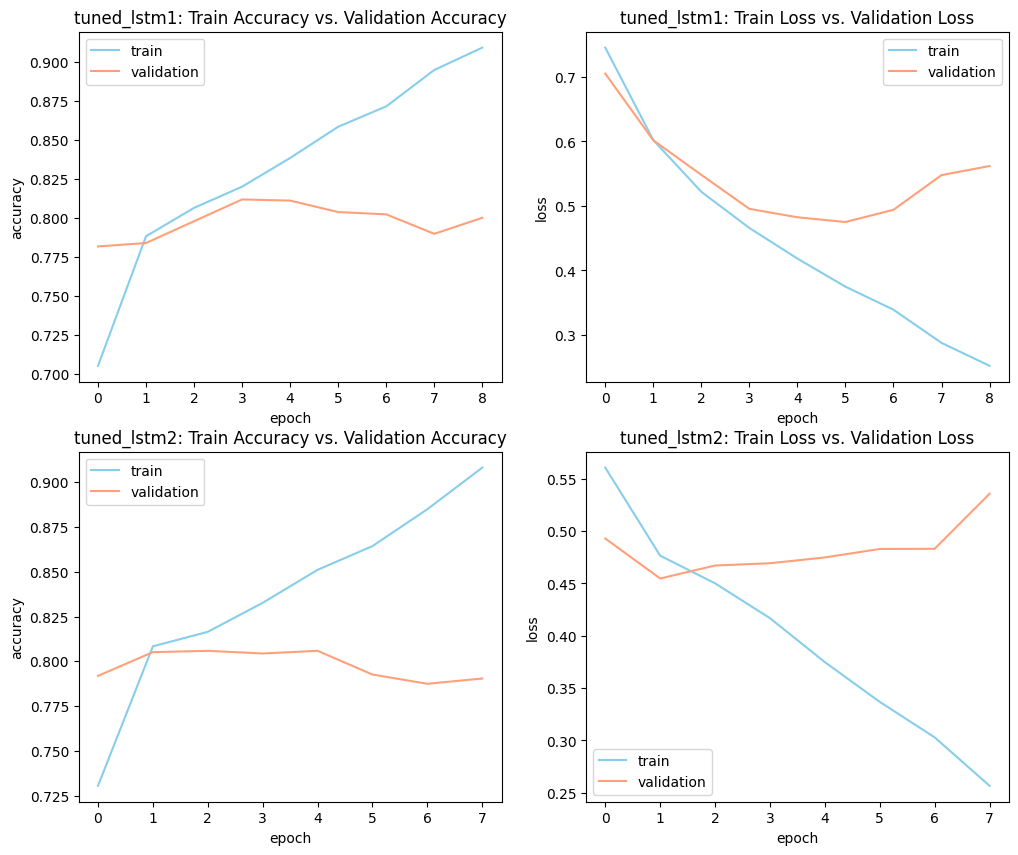

In [ ]:
# Create dataframes of the three models' history
tuned_lstm1_history = pd.DataFrame({
    'dataset': ['train'] * 9 + ['validation'] * 9,
    'epoch': list(range(9)) * 2,
    'loss': history_tuned_lstm1.history['loss'] + history_tuned_lstm1.history['val_loss'],
    'accuracy': history_tuned_lstm1.history['accuracy'] + history_tuned_lstm1.history['val_accuracy']
})

tuned_lstm2_history = pd.DataFrame({
    'dataset': ['train'] * 8 + ['validation'] * 8,
    'epoch': list(range(8)) * 2,
    'loss': history_tuned_lstm2.history['loss'] + history_tuned_lstm2.history['val_loss'],
    'accuracy': history_tuned_lstm2.history['accuracy'] + history_tuned_lstm2.history['val_accuracy']
})


# Plot the training and validation accuracy and loss
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10))
axes = axes.flatten()

sns.lineplot(data = tuned_lstm1_history, x = 'epoch', y = 'accuracy', hue = 'dataset',
             palette = ['skyblue', 'lightsalmon'], ax = axes[0])
axes[0].set_title('tuned_lstm1: Train Accuracy vs. Validation Accuracy')
axes[0].legend(title = '');

sns.lineplot(data = tuned_lstm1_history, x = 'epoch', y = 'loss', hue = 'dataset',
             palette = ['skyblue', 'lightsalmon'], ax = axes[1])
axes[1].set_title('tuned_lstm1: Train Loss vs. Validation Loss')
axes[1].legend(title = '');

sns.lineplot(data = tuned_lstm2_history, x = 'epoch', y = 'accuracy', hue = 'dataset',
             palette = ['skyblue', 'lightsalmon'], ax = axes[2])
axes[2].set_title('tuned_lstm2: Train Accuracy vs. Validation Accuracy')
axes[2].legend(title = '');

sns.lineplot(data = tuned_lstm2_history, x = 'epoch', y = 'loss', hue = 'dataset',
             palette = ['skyblue', 'lightsalmon'], ax = axes[3])
axes[3].set_title('tuned_lstm2: Train Loss vs. Validation Loss')
axes[3].legend(title = '');

The training history plots above show that both models has overfitting after a few epochs, while the metrics of validation set in the first one seems more smooth. I will make prediction on the test set using both models, then submit to Kaggle

In [ ]:
# Get BERT Embeddings for test dataset
test_embeddings = bert_embedding(clean_test['cleaned_text'])

# Save the embeddings as a Numpy file
np.save('/content/drive/MyDrive/ColabNotebooks/Disaster_tweets/test_embeddings.npy', test_embeddings)


In [ ]:
# make prediction
pred_test_tuned_lstm1 = tuned_lstm1.predict(test_embeddings, verbose = 0)
pred_test_tuned_lstm1 = np.round(pred_test_tuned_lstm1).astype(int)

pred_test_tuned_lstm2 = tuned_lstm2.predict(test_embeddings, verbose = 0)
pred_test_tuned_lstm2 = np.round(pred_test_tuned_lstm2).astype(int)

In [ ]:
# Create two submission dataframes
submission_tuned_lstm1 = pd.DataFrame({
    'id': clean_test['id'],
    'target': pred_test_tuned_lstm1.reshape(-1)
})

submission_tuned_lstm2 = pd.DataFrame({
    'id': clean_test['id'],
    'target': pred_test_tuned_lstm2.reshape(-1)
})

In [ ]:
submission_tuned_lstm1.to_csv('/content/drive/MyDrive/ColabNotebooks/Disaster_tweets/submission_tuned_lstm1.csv', index = False)
submission_tuned_lstm2.to_csv('/content/drive/MyDrive/ColabNotebooks/Disaster_tweets/submission_tuned_lstm2.csv', index = False)

After submit the prediction to Kaggle, I got the result as follows:
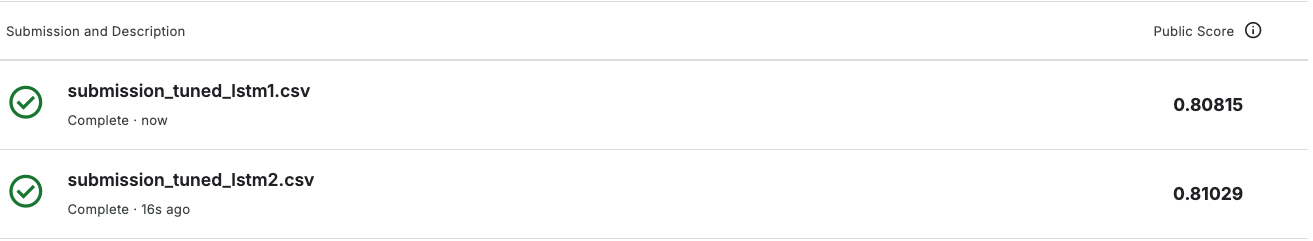


# Conclusion

In this project, I built multiple LSTM models to predict whether a given tweet is about a real disaster (class 1) or not (class 0). After hyperparameter tuning, I identified two best models in terms of F1 score and precision. I then made predictions on the test set and submitted the results to Kaggle. The results show that the ‘tuned_lstm2’ model achieved a slightly higher F1 score on the test set.

I also experimented with incorporating meta features and linguistic features that were statistically significantly different between the two classes. However, this did not improve the model’s performance.

The history plot indicates that the tuned models still suffer from overfitting, despite using L2 regularization, dropout, batch normalization, and reducing the number of units in both the LSTM and Dense layers. A larger dataset might help mitigate the overfitting issue.